# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
import imageio
import datetime
import os
from sys import getsizeof
from PIL import Image
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

### Plotting

In [6]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
frames_to_sample = 30 # number of frames to use
total_frames = 30 # number of frames
img_width = 120 # image width
img_height = 120 # image height

In [8]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0, total_frames-1, frames_to_sample)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_width,img_height,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resize_img = image.resize((img_height,img_width))
                    nor_img = np.array(resize_img)/255
                    
                    batch_data[folder,idx,:,:,0] = (nor_img[:,:,0])
                    batch_data[folder,idx,:,:,1] = (nor_img[:,:,1])
                    batch_data[folder,idx,:,:,2] = (nor_img[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            batch_data = np.zeros((batch_size,len(img_idx),img_width,img_height,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resize_img = image.resize((img_height,img_width))
                    nor_img = np.array(resize_img)/255
                    
                    batch_data[folder,idx,:,:,0] = (nor_img[:,:,0])
                    batch_data[folder,idx,:,:,1] = (nor_img[:,:,1])
                    batch_data[folder,idx,:,:,2] = (nor_img[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [9]:
def train_model(model, batch_size, num_epochs = 10):
    # generators
    train_generator = generator(train_path, train_doc, batch_size)
    val_generator = generator(val_path, val_doc, batch_size)
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
    callbacks_list = [checkpoint, LR]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    return history

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 :

In [13]:
frames_to_sample = 30 # number of frames to use
total_frames = 30 # number of frames
img_width = 120 # image width
img_height = 120 # image height

In [14]:
model = Sequential()
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same',input_shape=(frames_to_sample,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5 ,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 60, 60, 32)   

ResourceExhaustedError:  OOM when allocating tensor with shape[50,8,30,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [17]:
history_model1 = train_model(model,batch_size = 10, num_epochs = 15)

Source path =  Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - 64s 942ms/step - loss: 1.6055 - categorical_accuracy: 0.4027 - val_loss: 2.2802 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.60548-0.40271-2.28024-0.16000.h5
Epoch 2/15
67/67 [==============================] - 26s 388ms/step - loss: 1.8846 - categorical_accuracy: 0.3184 - val_loss: 10.0116 - val_categorical_accuracy: 0.2700

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.88457-0.31841-10.01159-0.27000.h5
Epoch 3/15
67/67 [==============================] - 26s 395ms/step - loss: 1.9060 - categorical_accuracy: 0.3035 - val_loss: 2.0205 - val_categorical_accuracy: 0.2800

Epoch 00003: saving model to model_init_2021-02-0619_33_50.122405\model-00003-1.90598-0.30348-2.02047-0.28000.h5
Epoch 4/15
67/67 [==============================] - 25s 381ms/step - loss: 1.8766 - categorical_accurac

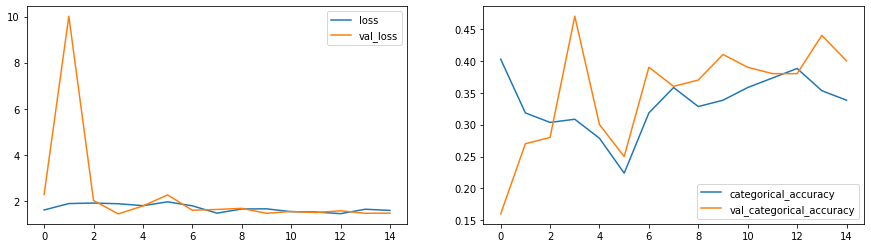

In [18]:
plot(history_model1)

We are getting a train accuracy of 37% and validation accuracy of 38%.

# Model 2 :

In [19]:
frames_to_sample = 18 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height

In [20]:
model = Sequential()
model.add(Conv3D(16, kernel_size=(3,3,3), padding='same',input_shape=(frames_to_sample,img_height,img_width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(5 ,activation='softmax'))

In [21]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 18, 100, 100, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 18, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 18, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 9, 50, 50, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 9, 50, 50, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 9, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 9, 50, 50, 32)    

In [22]:
history_model2 = train_model(model,batch_size = 30, num_epochs = 15)

Source path =  Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.7863 - categorical_accuracy: 0.3517Source path =  Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 38s 2s/step - loss: 1.7792 - categorical_accuracy: 0.3537 - val_loss: 1.4941 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.61549-0.39970-1.49407-0.24000.h5
Epoch 2/15
23/23 [==============================] - 6s 256ms/step - loss: 1.7285 - categorical_accuracy: 0.3658 - val_loss: 1.7320 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.87726-0.30435-1.73204-0.20000.h5
Epoch 3/15
23/23 [==============================] - 6s 287ms/step - loss: 1.9534 - categorical_accuracy: 0.3529 - val_loss: 2.7378 - val_categorical_accuracy: 0.2750

Epoch 00003: saving model to model_init_2021-02-0619_33_50.

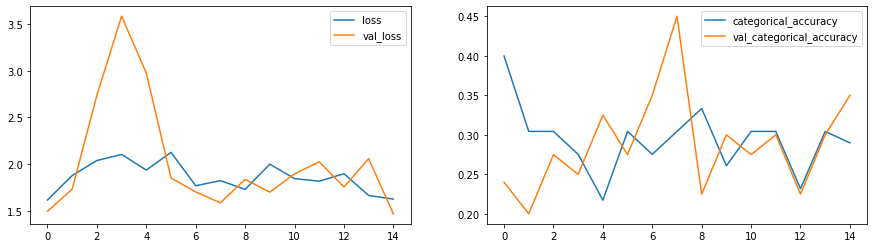

In [23]:
plot(history_model2)

We are getting a train accuracy of 31% and validation accuracy of 30%.

## Model 3:

In [24]:
frames_to_sample = 30 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height

In [25]:
model_a = Sequential()

model_a.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(frames_to_sample, img_height, img_width, 3),
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

model_a.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_a.add(BatchNormalization())
model_a.add(Activation('relu'))

model_a.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_a.add(Flatten())

model_a.add(Dense(1000, activation='relu'))
model_a.add(Dropout(0.5))

model_a.add(Dense(500, activation='relu'))
model_a.add(Dropout(0.5))

#softmax layer
model_a.add(Dense(5, activation='softmax'))

In [26]:
optimiser = optimizers.Adam() #write your optimizer
model_a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_a.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 100, 100, 8)   32        
_________________________________________________________________
activation_12 (Activation)   (None, 30, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 50, 50, 8)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 50, 50, 16)    64        
_________________________________________________________________
activation_13 (Activation)   (None, 15, 50, 50, 16)   

In [27]:
history_model3 = train_model(model_a, batch_size = 30, num_epochs = 15)

Source path =  Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 4.5692 - categorical_accuracy: 0.2349Source path =  Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 61s 3s/step - loss: 4.5117 - categorical_accuracy: 0.2366 - val_loss: 1.5483 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-3.18910-0.27602-1.54827-0.33000.h5
Epoch 2/15
23/23 [==============================] - 10s 470ms/step - loss: 1.4604 - categorical_accuracy: 0.4003 - val_loss: 1.7743 - val_categorical_accuracy: 0.1750

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.62521-0.39130-1.77432-0.17500.h5
Epoch 3/15
23/23 [==============================] - 9s 427ms/step - loss: 1.5150 - categorical_accuracy: 0.3243 - val_loss: 2.4465 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to model_init_2021-02-0619_33_50

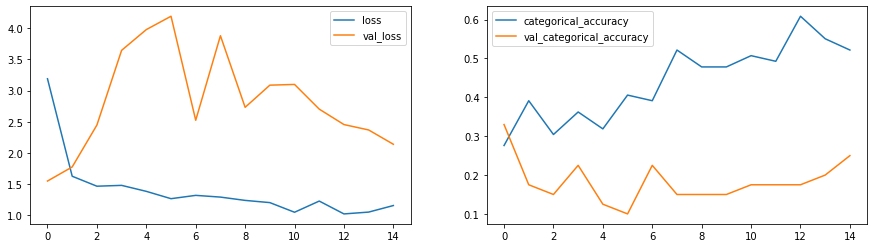

In [28]:
plot(history_model3)

We are getting a train accuracy of 60% and validation accuracy of 25%.
The model is overfitting.

### Model 4:

In [29]:
history_model4 = train_model(model_a, batch_size = 30, num_epochs = 25)

Source path =  Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.0403 - categorical_accuracy: 0.5445Source path =  Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 60s 3s/step - loss: 1.0403 - categorical_accuracy: 0.5445 - val_loss: 1.9245 - val_categorical_accuracy: 0.2600

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.04033-0.54449-1.92450-0.26000.h5
Epoch 2/25
23/23 [==============================] - 11s 484ms/step - loss: 1.1204 - categorical_accuracy: 0.4493 - val_loss: 1.6457 - val_categorical_accuracy: 0.3250

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.12040-0.44928-1.64565-0.32500.h5
Epoch 3/25
23/23 [==============================] - 10s 449ms/step - loss: 1.1110 - categorical_accuracy: 0.5362 - val_loss: 1.5884 - val_categorical_accuracy: 0.2750

Epoch 00003: saving model to model_init_2021-02-0619_33_5

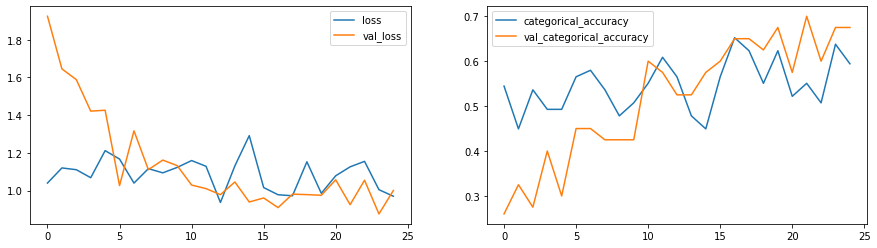

In [30]:
plot(history_model4)

We train the model for more epochs.The model tain accuracy is 63% and validation accuracy is 67%.

### Model 5

In [31]:
frames_to_sample = 30 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height

In [32]:
# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(frames_to_sample, img_height, img_width, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(5, activation='softmax'))

In [33]:
optimiser = optimizers.Adam() #write your optimizer
model_b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_b.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_17 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 20, 20, 64)   

In [34]:
history_model5 = train_model(model_b,batch_size = 40, num_epochs = 30)

Source path =  Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.8557 - categorical_accuracy: 0.2004Source path =  Project_data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 59s 3s/step - loss: 1.8478 - categorical_accuracy: 0.2005 - val_loss: 1.6095 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.71358-0.20211-1.60949-0.20000.h5
Epoch 2/30
17/17 [==============================] - 34s 2s/step - loss: 1.6099 - categorical_accuracy: 0.1681 - val_loss: 1.6113 - val_categorical_accuracy: 0.2167

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.60957-0.17647-1.61130-0.21667.h5
Epoch 3/30
17/17 [==============================] - 33s 2s/step - loss: 1.6099 - categorical_accuracy: 0.1719 - val_loss: 1.6080 - val_categorical_accuracy: 0.2167

Epoch 00003: saving model to model_init_2021-02-0619_33_50.1224

17/17 [==============================] - 26s 2s/step - loss: 0.2634 - categorical_accuracy: 0.8960 - val_loss: 0.5452 - val_categorical_accuracy: 0.8333

Epoch 00027: saving model to model_init_2021-02-0619_33_50.122405\model-00027-0.28171-0.89619-0.54517-0.83333.h5
Epoch 28/30
17/17 [==============================] - 27s 2s/step - loss: 0.3830 - categorical_accuracy: 0.8607 - val_loss: 0.4864 - val_categorical_accuracy: 0.8500

Epoch 00028: saving model to model_init_2021-02-0619_33_50.122405\model-00028-0.37790-0.85813-0.48638-0.85000.h5

Epoch 00028: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 29/30
17/17 [==============================] - 26s 2s/step - loss: 0.2801 - categorical_accuracy: 0.9100 - val_loss: 0.3972 - val_categorical_accuracy: 0.8833

Epoch 00029: saving model to model_init_2021-02-0619_33_50.122405\model-00029-0.28115-0.91003-0.39722-0.88333.h5
Epoch 30/30
17/17 [==============================] - 27s 2s/step - loss: 0.2608 - categorical_

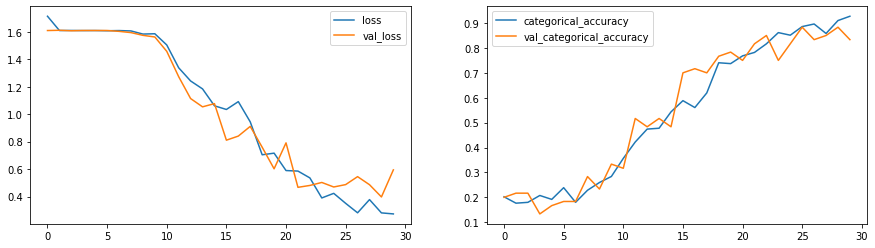

In [35]:
plot(history_model5)

The train accuracy is 91% and the validation accuracy is 88%.

### Model 6:

In [37]:
history_model6 = train_model(model_b,batch_size = 40, num_epochs = 40)

Source path =  Project_data/train ; batch size = 40
Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 0.3426 - categorical_accuracy: 0.8733Source path =  Project_data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 56s 3s/step - loss: 0.3426 - categorical_accuracy: 0.8733 - val_loss: 0.4484 - val_categorical_accuracy: 0.8400

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-0.34262-0.87330-0.44838-0.84000.h5
Epoch 2/40
17/17 [==============================] - 32s 2s/step - loss: 0.3061 - categorical_accuracy: 0.9130 - val_loss: 0.4763 - val_categorical_accuracy: 0.8833

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-0.30612-0.91304-0.47632-0.88333.h5
Epoch 3/40
17/17 [==============================] - 31s 2s/step - loss: 0.2931 - categorical_accuracy: 0.8883 - val_loss: 0.6454 - val_categorical_accuracy: 0.7667

Epoch 00003: saving model to model_init_2021-02-0619_33_50.1224

17/17 [==============================] - 26s 2s/step - loss: 0.2562 - categorical_accuracy: 0.9170 - val_loss: 0.4249 - val_categorical_accuracy: 0.8667

Epoch 00025: saving model to model_init_2021-02-0619_33_50.122405\model-00025-0.25617-0.91695-0.42491-0.86667.h5
Epoch 26/40
17/17 [==============================] - 27s 2s/step - loss: 0.3054 - categorical_accuracy: 0.8720 - val_loss: 0.5755 - val_categorical_accuracy: 0.8333

Epoch 00026: saving model to model_init_2021-02-0619_33_50.122405\model-00026-0.30540-0.87197-0.57546-0.83333.h5

Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 27/40
17/17 [==============================] - 27s 2s/step - loss: 0.2722 - categorical_accuracy: 0.9204 - val_loss: 0.4857 - val_categorical_accuracy: 0.8000

Epoch 00027: saving model to model_init_2021-02-0619_33_50.122405\model-00027-0.27224-0.92042-0.48572-0.80000.h5
Epoch 28/40
17/17 [==============================] - 24s 1s/step - loss: 0.2396 - categorical_

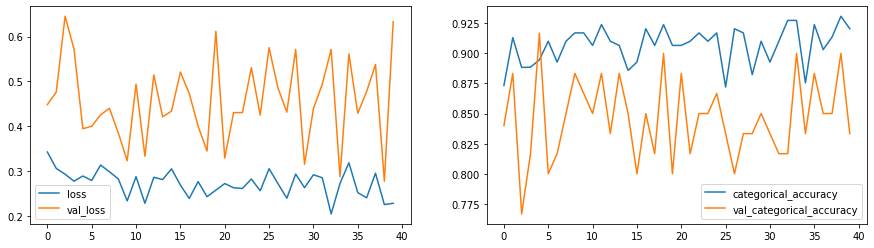

In [38]:
plot(history_model6)

The train accuracy is 93% and the validation accuracy is 90%.

### Model 7

In [39]:
frames_to_sample = 24 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height

In [40]:
# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(frames_to_sample, img_height, img_width, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(256, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(5, activation='softmax'))

In [41]:
optimiser = optimizers.Adam() #write your optimizer
model_b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_b.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 24, 60, 60, 32)    2624      
_________________________________________________________________
activation_20 (Activation)   (None, 24, 60, 60, 32)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 24, 60, 60, 32)    27680     
_________________________________________________________________
activation_21 (Activation)   (None, 24, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 8, 20, 20, 32)     0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 20, 20, 32)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 8, 20, 20, 64)    

In [42]:
history_model7 = train_model(model_b,batch_size = 40, num_epochs = 20)

Source path =  Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.6434 - categorical_accuracy: 0.2323Source path =  Project_data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 47s 3s/step - loss: 1.6422 - categorical_accuracy: 0.2321 - val_loss: 1.5892 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.62234-0.22926-1.58922-0.25000.h5
Epoch 2/20
17/17 [==============================] - 26s 2s/step - loss: 1.5683 - categorical_accuracy: 0.2362 - val_loss: 1.4620 - val_categorical_accuracy: 0.5333

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.55063-0.27621-1.46204-0.53333.h5
Epoch 3/20
17/17 [==============================] - 26s 2s/step - loss: 1.4343 - categorical_accuracy: 0.3525 - val_loss: 1.0046 - val_categorical_accuracy: 0.6333

Epoch 00003: saving model to model_init_2021-02-0619_33_50.1224

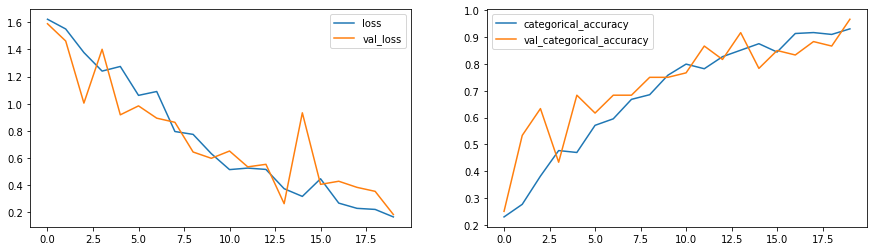

In [43]:
plot(history_model7)

After reducing the parameters the train and validation accuracy is 94% and 96%.

### Model 8:

In [44]:
history_model8 = train_model(model_b,batch_size = 40, num_epochs = 30)

Source path =  Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.1408 - categorical_accuracy: 0.9517Source path =  Project_data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 44s 3s/step - loss: 0.1408 - categorical_accuracy: 0.9517 - val_loss: 0.3508 - val_categorical_accuracy: 0.8800

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-0.14078-0.95173-0.35075-0.88000.h5
Epoch 2/30
17/17 [==============================] - 26s 2s/step - loss: 0.1446 - categorical_accuracy: 0.9514 - val_loss: 0.4762 - val_categorical_accuracy: 0.8167

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-0.14465-0.95141-0.47620-0.81667.h5
Epoch 3/30
17/17 [==============================] - 25s 2s/step - loss: 0.1471 - categorical_accuracy: 0.9510 - val_loss: 0.2156 - val_categorical_accuracy: 0.9167

Epoch 00003: saving model to model_init_2021-02-0619_33_50.1224

17/17 [==============================] - 21s 1s/step - loss: 0.0972 - categorical_accuracy: 0.9689 - val_loss: 0.3779 - val_categorical_accuracy: 0.9000

Epoch 00025: saving model to model_init_2021-02-0619_33_50.122405\model-00025-0.09724-0.96886-0.37788-0.90000.h5

Epoch 00025: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 26/30
17/17 [==============================] - 21s 1s/step - loss: 0.0681 - categorical_accuracy: 0.9792 - val_loss: 0.4044 - val_categorical_accuracy: 0.8500

Epoch 00026: saving model to model_init_2021-02-0619_33_50.122405\model-00026-0.06807-0.97924-0.40443-0.85000.h5
Epoch 27/30
17/17 [==============================] - 21s 1s/step - loss: 0.0846 - categorical_accuracy: 0.9723 - val_loss: 0.3442 - val_categorical_accuracy: 0.8833

Epoch 00027: saving model to model_init_2021-02-0619_33_50.122405\model-00027-0.08458-0.97232-0.34421-0.88333.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 28/30

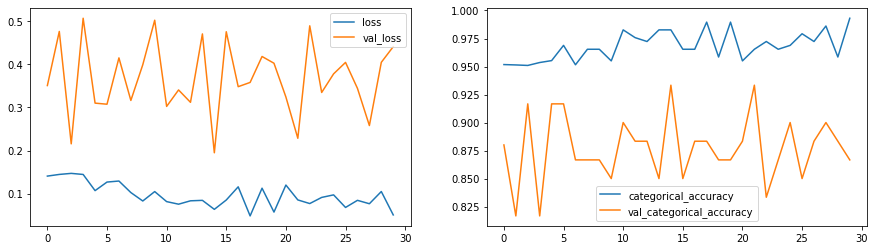

In [45]:
plot(history_model8)

After running for more epochs there is slight imporvement in the accuracy.

### Model 9

In [46]:
frames_to_sample = 18 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height

In [47]:
# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(frames_to_sample, img_height, img_width, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(128, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(5, activation='softmax'))

In [48]:
optimiser = optimizers.Adam() #write your optimizer
model_b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_b.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 18, 60, 60, 32)    2624      
_________________________________________________________________
activation_24 (Activation)   (None, 18, 60, 60, 32)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 18, 60, 60, 32)    27680     
_________________________________________________________________
activation_25 (Activation)   (None, 18, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 6, 20, 20, 32)     0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 6, 20, 20, 32)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 6, 20, 20, 64)    

In [49]:
history_model9 = train_model(model_b,batch_size = 40, num_epochs = 30)

Source path =  Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.6938 - categorical_accuracy: 0.2056Source path =  Project_data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 36s 2s/step - loss: 1.6911 - categorical_accuracy: 0.2056 - val_loss: 1.6027 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.64435-0.20513-1.60270-0.27000.h5
Epoch 2/30
17/17 [==============================] - 20s 1s/step - loss: 1.5962 - categorical_accuracy: 0.1987 - val_loss: 1.5502 - val_categorical_accuracy: 0.2167

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.59141-0.18670-1.55020-0.21667.h5
Epoch 3/30
17/17 [==============================] - 20s 1s/step - loss: 1.5429 - categorical_accuracy: 0.2780 - val_loss: 1.3528 - val_categorical_accuracy: 0.4167

Epoch 00003: saving model to model_init_2021-02-0619_33_50.1224

17/17 [==============================] - 16s 991ms/step - loss: 0.3095 - categorical_accuracy: 0.8671 - val_loss: 0.3766 - val_categorical_accuracy: 0.8667

Epoch 00026: saving model to model_init_2021-02-0619_33_50.122405\model-00026-0.32313-0.85467-0.37655-0.86667.h5
Epoch 27/30
17/17 [==============================] - 16s 948ms/step - loss: 0.2126 - categorical_accuracy: 0.9244 - val_loss: 0.4857 - val_categorical_accuracy: 0.8667

Epoch 00027: saving model to model_init_2021-02-0619_33_50.122405\model-00027-0.23372-0.92388-0.48574-0.86667.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 28/30
17/17 [==============================] - 16s 970ms/step - loss: 0.2846 - categorical_accuracy: 0.8818 - val_loss: 0.3804 - val_categorical_accuracy: 0.8833

Epoch 00028: saving model to model_init_2021-02-0619_33_50.122405\model-00028-0.28471-0.89273-0.38038-0.88333.h5
Epoch 29/30
17/17 [==============================] - 16s 975ms/step - loss: 0.2714 -

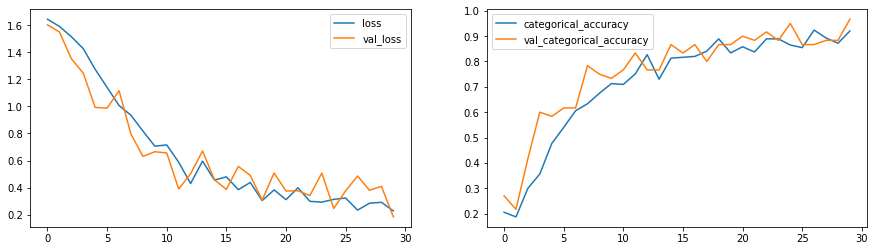

In [50]:
plot(history_model9)

We have reduced the model paramenters to 1 million. 
The accuracy is still train 92% and validation 96%.

### Model 10:

In [ ]:
frames_to_sample = 18 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height

In [67]:
# Define model b
model_b = Sequential()
model_b.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=(frames_to_sample, img_height, img_width, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(128, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(5, activation='softmax'))

In [68]:
optimiser = optimizers.Adam() #write your optimizer
model_b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_b.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_44 (Conv3D)           (None, 18, 60, 60, 16)    1312      
_________________________________________________________________
activation_44 (Activation)   (None, 18, 60, 60, 16)    0         
_________________________________________________________________
conv3d_45 (Conv3D)           (None, 18, 60, 60, 16)    6928      
_________________________________________________________________
activation_45 (Activation)   (None, 18, 60, 60, 16)    0         
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 6, 20, 20, 16)     0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 6, 20, 20, 16)     0         
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 6, 20, 20, 32)   

In [69]:
history_model11 = train_model(model_b,batch_size = 50, num_epochs = 30)

Source path =  Project_data/train ; batch size = 50
Epoch 1/30
14/14 [==============================] - 34s 2s/step - loss: 1.6399 - categorical_accuracy: 0.1660 - val_loss: 1.5988 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.62175-0.18854-1.59881-0.23000.h5
Epoch 2/30
14/14 [==============================] - 15s 1s/step - loss: 1.6001 - categorical_accuracy: 0.1944 - val_loss: 1.5727 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.60078-0.20879-1.57274-0.29000.h5
Epoch 3/30
14/14 [==============================] - 14s 1s/step - loss: 1.5821 - categorical_accuracy: 0.2607 - val_loss: 1.5893 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-02-0619_33_50.122405\model-00003-1.54914-0.28571-1.58929-0.23000.h5
Epoch 4/30
14/14 [==============================] - 14s 1s/step - loss: 1.5494 - categorical_accuracy: 0.2861 - va

14/14 [==============================] - 14s 1s/step - loss: 0.4047 - categorical_accuracy: 0.8326 - val_loss: 0.4668 - val_categorical_accuracy: 0.8100

Epoch 00028: saving model to model_init_2021-02-0619_33_50.122405\model-00028-0.40382-0.82967-0.46677-0.81000.h5
Epoch 29/30
14/14 [==============================] - 15s 1s/step - loss: 0.3240 - categorical_accuracy: 0.8757 - val_loss: 0.4578 - val_categorical_accuracy: 0.8400

Epoch 00029: saving model to model_init_2021-02-0619_33_50.122405\model-00029-0.41106-0.83516-0.45781-0.84000.h5
Epoch 30/30
14/14 [==============================] - 14s 1s/step - loss: 0.5181 - categorical_accuracy: 0.8062 - val_loss: 0.5147 - val_categorical_accuracy: 0.8200

Epoch 00030: saving model to model_init_2021-02-0619_33_50.122405\model-00030-0.52980-0.80220-0.51466-0.82000.h5


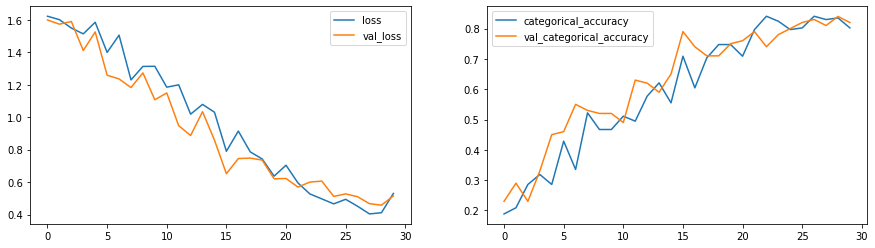

In [70]:
plot(history_model11)

After reducing the parameters more to about 4.5 lakhs we are getting an accuracy of about 87% train and 84% validation.
This is the model which we can use for deployment.

### Model 11:

In [56]:
frames_to_sample = 18 # number of frames to use
total_frames = 30 # number of frames
img_width = 60 # image width
img_height = 60 # image height

In [63]:
# Define model b
model_b = Sequential()
model_b.add(Conv3D(16, kernel_size=(3, 3, 3), input_shape=(frames_to_sample, img_height, img_width, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(16, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(64, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(5, activation='softmax'))

In [64]:
optimiser = optimizers.Adam() #write your optimizer
model_b.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_b.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 18, 60, 60, 16)    1312      
_________________________________________________________________
activation_40 (Activation)   (None, 18, 60, 60, 16)    0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 18, 60, 60, 16)    6928      
_________________________________________________________________
activation_41 (Activation)   (None, 18, 60, 60, 16)    0         
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 6, 20, 20, 16)     0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 6, 20, 20, 16)     0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 6, 20, 20, 32)   

In [65]:
history_model10 = train_model(model_b,batch_size = 40, num_epochs = 30)

Source path =  Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.6256 - categorical_accuracy: 0.1972Source path =  Project_data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 34s 2s/step - loss: 1.6249 - categorical_accuracy: 0.1985 - val_loss: 1.5935 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.61280-0.22021-1.59353-0.24000.h5
Epoch 2/30
17/17 [==============================] - 19s 1s/step - loss: 1.5822 - categorical_accuracy: 0.2515 - val_loss: 1.5203 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.57864-0.24297-1.52034-0.30000.h5
Epoch 3/30
17/17 [==============================] - 19s 1s/step - loss: 1.5121 - categorical_accuracy: 0.2709 - val_loss: 1.2722 - val_categorical_accuracy: 0.5667

Epoch 00003: saving model to model_init_2021-02-0619_33_50.1224


Epoch 00026: saving model to model_init_2021-02-0619_33_50.122405\model-00026-0.40465-0.85121-0.60363-0.81667.h5

Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 27/30
17/17 [==============================] - 16s 964ms/step - loss: 0.4594 - categorical_accuracy: 0.8066 - val_loss: 0.4790 - val_categorical_accuracy: 0.8167

Epoch 00027: saving model to model_init_2021-02-0619_33_50.122405\model-00027-0.48679-0.79931-0.47904-0.81667.h5
Epoch 28/30
17/17 [==============================] - 15s 906ms/step - loss: 0.4133 - categorical_accuracy: 0.8560 - val_loss: 0.3465 - val_categorical_accuracy: 0.9167

Epoch 00028: saving model to model_init_2021-02-0619_33_50.122405\model-00028-0.44114-0.84775-0.34651-0.91667.h5
Epoch 29/30
17/17 [==============================] - 15s 940ms/step - loss: 0.5319 - categorical_accuracy: 0.8033 - val_loss: 0.5809 - val_categorical_accuracy: 0.8333

Epoch 00029: saving model to model_init_2021-02-0619_33_50.122405\model-

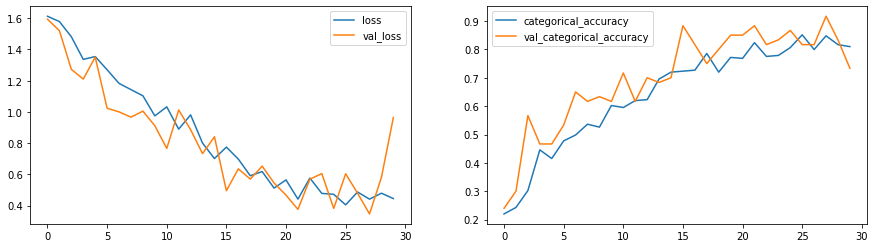

In [66]:
plot(history_model10)

We try to further reduce the model parameters but there is a drop in accuracy to about 80%.

### Model CNN-Lstm

In [72]:
frames_to_sample = 18 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height

In [73]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample, img_height,img_width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.25))
    
model.add(Dense(128 ,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [74]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 25, 25, 64)  

In [75]:
history_model12 = train_model(model,batch_size = 30, num_epochs = 30)

Source path =  Project_data/train ; batch size = 30
Epoch 1/30
22/23 [===========================>..] - ETA: 1s - loss: 1.5396 - categorical_accuracy: 0.3076Source path =  Project_data/val ; batch size = 30
Batch:  4 Index: 30
23/23 [==============================] - 38s 2s/step - loss: 1.5285 - categorical_accuracy: 0.3144 - val_loss: 1.5919 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.40604-0.38914-1.59188-0.27000.h5
Epoch 2/30
23/23 [==============================] - 6s 268ms/step - loss: 1.2942 - categorical_accuracy: 0.4078 - val_loss: 1.7110 - val_categorical_accuracy: 0.1750

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.32541-0.44928-1.71097-0.17500.h5
Epoch 3/30
23/23 [==============================] - 6s 274ms/step - loss: 1.1812 - categorical_accuracy: 0.5019 - val_loss: 1.9876 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-02-0619_33_50.

23/23 [==============================] - 5s 243ms/step - loss: 1.1981 - categorical_accuracy: 0.5129 - val_loss: 1.2065 - val_categorical_accuracy: 0.5750

Epoch 00026: saving model to model_init_2021-02-0619_33_50.122405\model-00026-1.12993-0.55072-1.20645-0.57500.h5
Epoch 27/30
23/23 [==============================] - 6s 282ms/step - loss: 1.2538 - categorical_accuracy: 0.4665 - val_loss: 1.1701 - val_categorical_accuracy: 0.5250

Epoch 00027: saving model to model_init_2021-02-0619_33_50.122405\model-00027-1.22435-0.42029-1.17012-0.52500.h5
Epoch 28/30
23/23 [==============================] - 6s 269ms/step - loss: 1.0637 - categorical_accuracy: 0.5902 - val_loss: 1.1609 - val_categorical_accuracy: 0.4750

Epoch 00028: saving model to model_init_2021-02-0619_33_50.122405\model-00028-1.15278-0.53623-1.16092-0.47500.h5
Epoch 29/30
23/23 [==============================] - 6s 278ms/step - loss: 1.0454 - categorical_accuracy: 0.5890 - val_loss: 1.0167 - val_categorical_accuracy: 0.6750

E

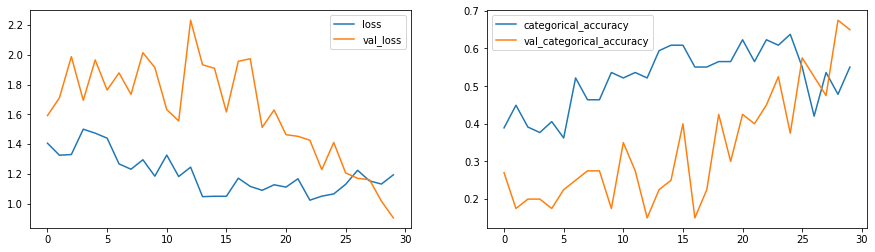

In [76]:
plot(history_model12)

We are getting an accuracy of 58% train and 67% validation .

### Model 13: CNN LSTM with GRU

In [77]:
frames_to_sample = 18 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height

In [79]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(frames_to_sample, img_height,img_width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
        
model.add(Dense(5, activation='softmax'))

In [80]:
optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_45 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_46 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_47 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_49 (TimeDis (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 18, 25, 25, 64)  

In [81]:
history_model13 = train_model(model,batch_size = 40, num_epochs = 30)

Source path =  Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.9250 - categorical_accuracy: 0.2360Source path =  Project_data/val ; batch size = 40
Batch:  3 Index: 40
17/17 [==============================] - 42s 2s/step - loss: 1.9142 - categorical_accuracy: 0.2385 - val_loss: 1.7440 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-1.72981-0.28054-1.74404-0.22000.h5
Epoch 2/30
17/17 [==============================] - 22s 1s/step - loss: 1.3968 - categorical_accuracy: 0.4087 - val_loss: 2.0495 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-1.34696-0.45780-2.04953-0.25000.h5
Epoch 3/30
17/17 [==============================] - 22s 1s/step - loss: 1.2523 - categorical_accuracy: 0.4910 - val_loss: 2.6474 - val_categorical_accuracy: 0.1667

Epoch 00003: saving model to model_init_2021-02-0619_33_50.1224

17/17 [==============================] - 17s 1s/step - loss: 0.6551 - categorical_accuracy: 0.7825 - val_loss: 2.1672 - val_categorical_accuracy: 0.3667

Epoch 00025: saving model to model_init_2021-02-0619_33_50.122405\model-00025-0.64797-0.79585-2.16721-0.36667.h5

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 26/30
17/17 [==============================] - 16s 1s/step - loss: 0.6113 - categorical_accuracy: 0.7857 - val_loss: 2.0550 - val_categorical_accuracy: 0.3333

Epoch 00026: saving model to model_init_2021-02-0619_33_50.122405\model-00026-0.63159-0.76471-2.05503-0.33333.h5
Epoch 27/30
17/17 [==============================] - 18s 1s/step - loss: 0.6680 - categorical_accuracy: 0.7673 - val_loss: 1.7895 - val_categorical_accuracy: 0.4000

Epoch 00027: saving model to model_init_2021-02-0619_33_50.122405\model-00027-0.67927-0.77163-1.78946-0.40000.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 28/30


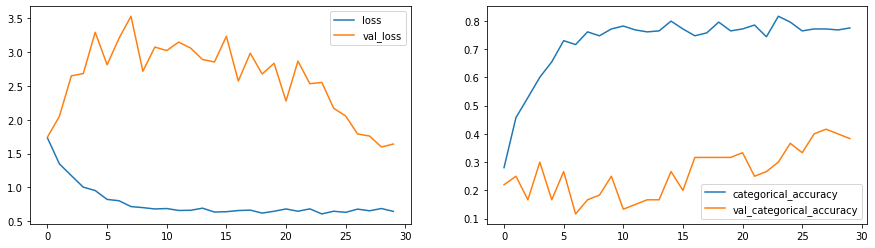

In [82]:
plot(history_model13)

This model is overfitting a lot.

### Model 14:Transfer learning

In [83]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 2s 0us/step


In [84]:
frames_to_sample = 18 # number of frames to use
total_frames = 30 # number of frames
img_width = 100 # image width
img_height = 100 # image height

In [85]:
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(frames_to_sample, img_height,img_width, 3)))
 
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [86]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_58 (TimeDis (None, 18, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_59 (TimeDis (None, 18, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_60 (TimeDis (None, 18, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_61 (TimeDis (None, 18, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)             

In [89]:
history_model14 = train_model(model,batch_size = 10, num_epochs = 20)

Source path =  Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 44s 640ms/step - loss: 0.8735 - categorical_accuracy: 0.6772 - val_loss: 0.4472 - val_categorical_accuracy: 0.8400

Epoch 00001: saving model to model_init_2021-02-0619_33_50.122405\model-00001-0.87351-0.67722-0.44718-0.84000.h5
Epoch 2/20
67/67 [==============================] - 17s 259ms/step - loss: 0.6971 - categorical_accuracy: 0.7363 - val_loss: 0.7506 - val_categorical_accuracy: 0.6900

Epoch 00002: saving model to model_init_2021-02-0619_33_50.122405\model-00002-0.69706-0.73632-0.75060-0.69000.h5
Epoch 3/20
67/67 [==============================] - 18s 267ms/step - loss: 0.7361 - categorical_accuracy: 0.7164 - val_loss: 0.9409 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2021-02-0619_33_50.122405\model-00003-0.73611-0.71642-0.94086-0.65000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/67 [======

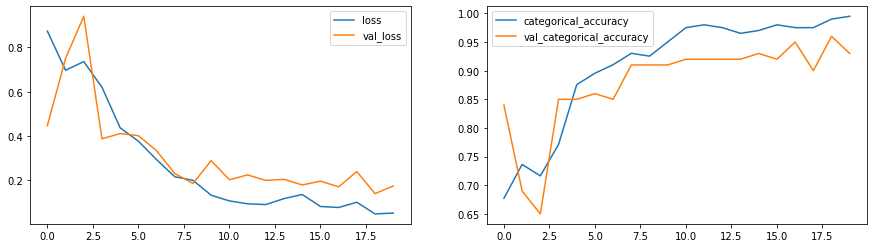

In [90]:
plot(history_model14)

We are getting a very good accuracy of train 99% and validation 96%.